In [ ]:
# get data
!wget -O surnames.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ji7dhr9FojPeV51dDlKRERIqr3vdZfhu"

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    
SEED = 41
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

In [2]:
data, labels = [], []
with open('surnames.txt') as f:
    for line in f:
        surname, lang = line.strip().split('\t')
        data.append(surname)
        labels.append(lang)

for i in np.random.randint(0, len(data), 10):
    print(data[i], labels[i])

Tuma Arabic
Antar Arabic
Filippi Italian
Turatbekov Russian
Minko Russian
De la fontaine French
Sui Chinese
Bacherikoff Russian
Detkov Russian
Dzhelepov Russian


## Split into training and test sets

In [3]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42
)

## Data Preprocessing

In [4]:
symbols = set(symb for word in data_train for symb in word)
char2ind = {symb: ind + 1 for ind, symb in enumerate(symbols)}
char2ind[''] = 0

# prepare index for labels
lang2ind = {lang: ind for ind, lang in enumerate(set(labels_train))}
print(lang2ind)

{'Polish': 0, 'German': 1, 'Irish': 2, 'Spanish': 3, 'Russian': 4, 'English': 5, 'Portuguese': 6, 'Italian': 7, 'French': 8, 'Korean': 9, 'Vietnamese': 10, 'Greek': 11, 'Chinese': 12, 'Dutch': 13, 'Czech': 14, 'Arabic': 15, 'Scottish': 16, 'Japanese': 17}


### Batch Preparation

In [5]:
def iterate_batches(data, 
                    labels, 
                    char2ind,
                    lang2ind,
                    batch_size
                   ):
    
    labels = np.array([lang2ind[label] for label in labels])
    data   = np.array([[char2ind.get(symb, 0) for symb in word] for word in data])
        
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    for start in range(0, len(data), batch_size):
        end = min(start + batch_size, len(data))
        
        batch_indices = indices[start: end]
        max_word_len  = max(len(data[ind]) for ind in batch_indices) 
        
        X = np.zeros((max_word_len, len(batch_indices)))
        
        for i, ind in enumerate(batch_indices):
            X[:len(data[ind]), i] = data[ind]
                    
        yield X, labels[batch_indices]

In [6]:
from functools import partial

iterate_batches = partial(iterate_batches, 
                          char2ind=char2ind,
                          lang2ind=lang2ind
                         )

In [7]:
next(iterate_batches(data, labels, batch_size=8))

(array([[69., 68., 80., 12., 69., 37., 82., 82.],
        [64., 28., 28., 49., 64., 16., 63., 16.],
        [43., 83., 30., 63., 28., 51., 35., 26.],
        [44., 49., 81., 20., 51., 30., 35., 16.],
        [51., 44., 26., 30., 25., 81., 43., 26.],
        [64., 28., 30., 51., 16., 57., 16.,  0.],
        [49., 16., 64.,  0.,  0.,  0., 76.,  0.],
        [76.,  0.,  0.,  0.,  0.,  0., 76.,  0.],
        [84.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([ 2,  4,  2,  2, 14,  2, 13,  7]))

### Model Definitions

In [7]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self._hidden_size = hidden_size
        self.linear_layer = nn.Linear(self._hidden_size + input_size, self._hidden_size)
        
    def forward(self, inputs, hidden=None):
        seq_len, batch_size = inputs.shape[:2]
        
        if hidden is None:
            hidden = inputs.new_zeros((batch_size), self._hidden_size)
        
        for i in range(seq_len):
            formatted_input = torch.cat((hidden, inputs[i]), dim=1)            
            hidden          = self.linear_layer(formatted_input)
        
        return hidden

In [8]:
class MemorizerModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        input_size     = 10
        self.embedding = nn.Embedding(input_size, input_size)
        self.embedding.weight = nn.Parameter(torch.eye(input_size))
        
        self.model     = nn.Sequential(self.embedding,
                                       SimpleRNN(input_size, hidden_size),
                                       nn.Linear(hidden_size, input_size)
                                      )
        
    def forward(self, inputs):
        return self.model(inputs)

### Train MemorizerModel

In [10]:
rnn = MemorizerModel(hidden_size=16)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss   = 0
epochs_count = 1000

for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=25)
    
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)
    
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

NameError: name 'generate_data' is not defined

In [ ]:
-np.log(1 / 10)

### Surname Classifier

In [9]:
class SurnamesClassifier(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 emb_dim, 
                 lstm_hidden_dim, 
                 classes_count):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)        
        self.model     = nn.Sequential(SimpleRNN(emb_dim, 
                                                 lstm_hidden_dim),
                                       nn.Linear(lstm_hidden_dim,
                                                 classes_count)
                                      )    
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        embeddings = self.embed(inputs)
        return self.model(embeddings)
    
    def embed(self, inputs):
        'inputs -> word embedding'
        return self.embedding(inputs)

In [10]:
class LSTMSurnamesClassifier(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 emb_dim, 
                 lstm_hidden_dim, 
                 classes_count):
        
        super().__init__()
        
        self.lstm_hidden_dim = lstm_hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)        
        self.lstm      = nn.LSTM(emb_dim, lstm_hidden_dim)
        self.output    = nn.Linear(lstm_hidden_dim, classes_count)
        
        self.dropout_layer = nn.Dropout(p=0.3)
        
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        
        self.hidden = self.init_hidden(inputs.size(-1))
        
        embeddings        = self.embed(inputs)
        outputs, (ht, ct) = self.lstm(embeddings, self.hidden)
        
        outputs           = self.dropout_layer(ht[-1])
        outputs           = self.output(outputs)
        
        return outputs
    
    def embed(self, inputs):
        'inputs -> word embedding'
        return self.embedding(inputs)
    
    def init_hidden(self, batch_size):
        return(torch.randn(1, batch_size, self.lstm_hidden_dim).cuda(),
               torch.randn(1, batch_size, self.lstm_hidden_dim).cuda())

In [11]:
class LSTMBidirectionalSurnamesClassifier(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 emb_dim, 
                 lstm_hidden_dim, 
                 classes_count):
        
        super().__init__()
        
        self.lstm_hidden_dim = lstm_hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)        
        self.lstm      = nn.LSTM(emb_dim, lstm_hidden_dim, num_layers=1, bidirectional=True)
        self.output    = nn.Linear(lstm_hidden_dim, classes_count)
        
        self.dropout_layer = nn.Dropout(p=0.3)
        
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        
        self.hidden = self.init_hidden(inputs.size(-1))
        
        embeddings        = self.embed(inputs)
        outputs, (ht, ct) = self.lstm(embeddings, self.hidden)
        
        outputs           = self.dropout_layer(ht[-1])
        outputs           = self.output(outputs)
        
        return outputs
    
    def embed(self, inputs):
        'inputs -> word embedding'
        return self.embedding(inputs)
    
    def init_hidden(self, batch_size):
        return(torch.ones(1 * 2, batch_size, self.lstm_hidden_dim).cuda(),
               torch.ones(1 * 2, batch_size, self.lstm_hidden_dim).cuda())

### Training Helper Methods

In [12]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):  
    epoch_loss = 0.
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(len(data) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size=batch_size)):
            X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.)
                optimizer.step()

            print('\r[{} / {}]: Loss = {:.4f}'.format(i, batchs_count, loss.item()), end='')
                
    return epoch_loss / batchs_count

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss = do_epoch(model, criterion, train_data, batch_size, optimizer)
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}'
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss, val_loss))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

### Training Loop

In [16]:
model = SurnamesClassifier(vocab_size=len(char2ind), 
                           emb_dim=16, 
                           lstm_hidden_dim=64, 
                           classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, 
    criterion, 
    optimizer, 
    epochs_count=60, 
    batch_size=128, 
    train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), 
    val_batch_size=512)

Epoch 1 / 60, Epoch Time = 0.68s: Train Loss = 1.9297, Val Loss = 2.1195
Epoch 2 / 60, Epoch Time = 0.67s: Train Loss = 1.6625, Val Loss = 1.7477
Epoch 3 / 60, Epoch Time = 0.76s: Train Loss = 1.5929, Val Loss = 1.6543
Epoch 4 / 60, Epoch Time = 0.66s: Train Loss = 1.5535, Val Loss = 1.5509
Epoch 5 / 60, Epoch Time = 0.67s: Train Loss = 1.5187, Val Loss = 1.5280
Epoch 6 / 60, Epoch Time = 0.67s: Train Loss = 1.5143, Val Loss = 1.6145
Epoch 7 / 60, Epoch Time = 0.67s: Train Loss = 1.4939, Val Loss = 1.5176
Epoch 8 / 60, Epoch Time = 0.77s: Train Loss = 1.4657, Val Loss = 1.5732
Epoch 9 / 60, Epoch Time = 0.66s: Train Loss = 1.4103, Val Loss = 1.5072
Epoch 10 / 60, Epoch Time = 0.66s: Train Loss = 1.3669, Val Loss = 1.4121
Epoch 11 / 60, Epoch Time = 0.67s: Train Loss = 1.3297, Val Loss = 1.4319
Epoch 12 / 60, Epoch Time = 0.67s: Train Loss = 1.3207, Val Loss = 1.3456
Epoch 13 / 60, Epoch Time = 0.77s: Train Loss = 1.2905, Val Loss = 1.3331
Epoch 14 / 60, Epoch Time = 0.67s: Train Loss =

In [46]:
# model = LSTMSurnamesClassifier(vocab_size=len(char2ind), 
#                            emb_dim=16, 
#                            lstm_hidden_dim=64, 
#                            classes_count=len(lang2ind)).cuda()

# criterion = nn.CrossEntropyLoss().cuda()
# optimizer = optim.Adam(model.parameters())

# fit(model, 
#     criterion, 
#     optimizer, 
#     epochs_count=60, 
#     batch_size=128, 
#     train_data=(data_train, labels_train),
#     val_data=(data_test, labels_test), 
#     val_batch_size=512)

Epoch 1 / 60, Epoch Time = 0.61s: Train Loss = 2.0339, Val Loss = 1.8448
Epoch 2 / 60, Epoch Time = 0.59s: Train Loss = 1.7295, Val Loss = 1.5453
Epoch 3 / 60, Epoch Time = 0.59s: Train Loss = 1.5380, Val Loss = 1.4748
Epoch 4 / 60, Epoch Time = 0.59s: Train Loss = 1.4994, Val Loss = 1.4570
Epoch 5 / 60, Epoch Time = 0.64s: Train Loss = 1.4550, Val Loss = 1.4015
Epoch 6 / 60, Epoch Time = 0.58s: Train Loss = 1.3786, Val Loss = 1.3291
Epoch 7 / 60, Epoch Time = 0.59s: Train Loss = 1.2901, Val Loss = 1.2606
Epoch 8 / 60, Epoch Time = 0.57s: Train Loss = 1.2337, Val Loss = 1.1637
Epoch 9 / 60, Epoch Time = 0.59s: Train Loss = 1.1752, Val Loss = 1.1367
Epoch 10 / 60, Epoch Time = 0.70s: Train Loss = 1.1249, Val Loss = 1.0762
Epoch 11 / 60, Epoch Time = 0.58s: Train Loss = 1.0878, Val Loss = 1.0537
Epoch 12 / 60, Epoch Time = 0.59s: Train Loss = 1.0578, Val Loss = 1.0184
Epoch 13 / 60, Epoch Time = 0.60s: Train Loss = 1.0300, Val Loss = 1.0207
Epoch 14 / 60, Epoch Time = 0.69s: Train Loss =

In [90]:
model = LSTMBidirectionalSurnamesClassifier(vocab_size=len(char2ind), 
                           emb_dim=32, 
                           lstm_hidden_dim=64, 
                           classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, 
    criterion, 
    optimizer, 
    epochs_count=60, 
    batch_size=128, 
    train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), 
    val_batch_size=512)

Epoch 1 / 60, Epoch Time = 1.14s: Train Loss = 1.8375, Val Loss = 1.6378
Epoch 2 / 60, Epoch Time = 1.14s: Train Loss = 1.4762, Val Loss = 1.4052
Epoch 3 / 60, Epoch Time = 1.12s: Train Loss = 1.3232, Val Loss = 1.3006
Epoch 4 / 60, Epoch Time = 1.12s: Train Loss = 1.1688, Val Loss = 1.1526
Epoch 5 / 60, Epoch Time = 1.08s: Train Loss = 1.0560, Val Loss = 1.0335
Epoch 6 / 60, Epoch Time = 1.17s: Train Loss = 0.9682, Val Loss = 0.9599
Epoch 7 / 60, Epoch Time = 1.05s: Train Loss = 0.8890, Val Loss = 0.8942
Epoch 8 / 60, Epoch Time = 1.06s: Train Loss = 0.8263, Val Loss = 0.8423
Epoch 9 / 60, Epoch Time = 1.09s: Train Loss = 0.7813, Val Loss = 0.8106
Epoch 10 / 60, Epoch Time = 1.07s: Train Loss = 0.7429, Val Loss = 0.7930
Epoch 11 / 60, Epoch Time = 1.07s: Train Loss = 0.7006, Val Loss = 0.7437
Epoch 12 / 60, Epoch Time = 1.20s: Train Loss = 0.6669, Val Loss = 0.7309
Epoch 13 / 60, Epoch Time = 1.03s: Train Loss = 0.6478, Val Loss = 0.7179
Epoch 14 / 60, Epoch Time = 0.99s: Train Loss =

In [84]:
def predict_surname(model, 
                    surname, 
                    char2ind):
    
    data    = np.array([char2ind.get(symb, 0) for symb in surname])
    max_len = len(surname) 
    
    X = np.zeros(shape=(max_len, 1))
    
    for i in range(X.shape[1]):
        for j, char in enumerate(data):
            X[j, i] = char
    
    logits          = model(LongTensor(X)).cpu().detach().numpy()
    max_logit_index = np.argmax(logits)
    
    return max_logit_index

In [85]:
model.eval()

y_pred = [predict_surname(model, surname, char2ind) for surname in data_test]
y_test = [lang2ind[label] for label in labels_test]

print('Accuracy = {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('Classification report:')
print(classification_report(y_test, y_pred, 
                            target_names=[lang for lang, _ in sorted(lang2ind.items(), key=lambda x: x[1])]))

Accuracy = 72.44%
Classification report:
              precision    recall  f1-score   support

       Czech       0.46      0.07      0.12       156
    Japanese       0.64      0.85      0.73       297
      Korean       0.54      0.25      0.34        28
      German       0.38      0.48      0.42       217
     English       0.56      0.80      0.66      1101
      Arabic       0.91      0.45      0.60       600
     Italian       0.56      0.49      0.53       213
      Polish       0.50      0.02      0.05        42
       Dutch       0.74      0.19      0.30        89
       Greek       0.56      0.66      0.60        61
  Portuguese       1.00      0.05      0.09        22
  Vietnamese       0.33      0.09      0.14        22
     Russian       0.88      0.92      0.90      2823
       Irish       0.33      0.49      0.40        70
      French       0.44      0.17      0.24        83
     Chinese       0.38      0.10      0.16        80
    Scottish       0.00      0.00      0

### Draw Vectors

In [49]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.colors import RGB
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    if isinstance(color, np.ndarray):
        color = [RGB(*x[:3]) for x in color]
    print(color)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

In [50]:
word_indices = np.random.choice(np.arange(len(data_test)), 1000, replace=False)
words        = [data_test[ind] for ind in word_indices]
word_labels  = [labels_test[ind] for ind in word_indices]

model.eval()
X_batch, y_batch = next(iterate_batches(words, word_labels, batch_size=1000))
embeddings       = model.embed(LongTensor(X_batch)).cpu().detach().numpy()[0]

colors = plt.cm.tab20(y_batch) * 255

visualize_embeddings(embeddings, words, colors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.167s
[t-SNE] Iteration 50: error = 49.1795235, gradient norm = 0.2384655 (50 iterations in 20.397s)
[t-SNE] Iteration 100: error = 40.5870743, gradient norm = 0.1699983 (50 iterations in 21.279s)
[t-SNE] Iteration 150: error = 38.2700424, gradient norm = 0.1581608 (50 iterations in 30.851s)
[t-SNE] Iteration 200: error = 37.1242561, gradient norm = 0.1366499 (50 iterations in 29.874s)
[t-SNE] Iteration 250: error = 36.2821884, gradient norm = 0.1275681 (50 iterations in 39.582s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.282188
[t-SNE] Iteration 300: error = 0.1524332, gradient norm = 0.0004948 (50 iterations in 40.254s)
[t-SNE] Iteration 350: error = 0.1023465, gradient norm = 0

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

[rgb(227, 119, 194), rgb(247, 182, 210), rgb(227, 119, 194), rgb(44, 160, 44), rgb(227, 119, 194), rgb(227, 119, 194), rgb(227, 119, 194), rgb(152, 223, 138), rgb(255, 187, 120), rgb(152, 223, 138), rgb(174, 199, 232), rgb(44, 160, 44), rgb(227, 119, 194), rgb(227, 119, 194), rgb(174, 199, 232), rgb(255, 187, 120), rgb(44, 160, 44), rgb(44, 160, 44), rgb(227, 119, 194), rgb(227, 119, 194), rgb(227, 119, 194), rgb(227, 119, 194), rgb(227, 119, 194), rgb(227, 119, 194), rgb(199, 199, 199), rgb(255, 127, 14), rgb(227, 119, 194), rgb(44, 160, 44), rgb(255, 187, 120), rgb(44, 160, 44), rgb(227, 119, 194), rgb(44, 160, 44), rgb(227, 119, 194), rgb(227, 119, 194), rgb(44, 160, 44), rgb(227, 119, 194), rgb(255, 187, 120), rgb(152, 223, 138), rgb(44, 160, 44), rgb(199, 199, 199), rgb(227, 119, 194), rgb(152, 223, 138), rgb(44, 160, 44), rgb(227, 119, 194), rgb(227, 119, 194), rgb(174, 199, 232), rgb(227, 119, 194), rgb(44, 160, 44), rgb(199, 199, 199), rgb(44, 160, 44), rgb(44, 160, 44), rgb(22

### RNN Visualizer

In [111]:
class LSTMVisualizer(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 emb_dim, 
                 lstm_hidden_dim, 
                 classes_count):
        
        super().__init__()
        
        self.lstm_hidden_dim = lstm_hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)        
        self.lstm      = nn.LSTM(emb_dim, lstm_hidden_dim)
        self.output    = nn.Linear(lstm_hidden_dim, classes_count)
        
        self.dropout_layer = nn.Dropout(p=0.3)
        
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        
        self.hidden = self.init_hidden(inputs.size(-1))
        
        embeddings        = self.embed(inputs)
        outputs, (ht, ct) = self.lstm(embeddings, self.hidden)
        self.hs           = outputs
        
        outputs           = self.dropout_layer(ht[-1])
        outputs           = self.output(outputs)
        
        return outputs
    
    def embed(self, inputs):
        'inputs -> word embedding'
        return self.embedding(inputs)
    
    def init_hidden(self, batch_size):
        return(torch.randn(1, batch_size, self.lstm_hidden_dim).cuda(),
               torch.randn(1, batch_size, self.lstm_hidden_dim).cuda())

In [112]:
model = LSTMVisualizer(vocab_size=len(char2ind), 
                       emb_dim=16, 
                       lstm_hidden_dim=64, 
                       classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, 
    criterion, 
    optimizer, 
    epochs_count=60, 
    batch_size=128, 
    train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), 
    val_batch_size=512)

Epoch 1 / 60, Epoch Time = 0.59s: Train Loss = 2.0034, Val Loss = 1.7784
Epoch 2 / 60, Epoch Time = 0.58s: Train Loss = 1.6650, Val Loss = 1.5037
Epoch 3 / 60, Epoch Time = 0.58s: Train Loss = 1.5211, Val Loss = 1.4890
Epoch 4 / 60, Epoch Time = 0.73s: Train Loss = 1.4947, Val Loss = 1.4554
Epoch 5 / 60, Epoch Time = 0.57s: Train Loss = 1.4479, Val Loss = 1.4015
Epoch 6 / 60, Epoch Time = 0.56s: Train Loss = 1.3801, Val Loss = 1.3484
Epoch 7 / 60, Epoch Time = 0.56s: Train Loss = 1.3219, Val Loss = 1.3073
Epoch 8 / 60, Epoch Time = 0.58s: Train Loss = 1.2870, Val Loss = 1.2504
Epoch 9 / 60, Epoch Time = 0.58s: Train Loss = 1.2531, Val Loss = 1.2368
Epoch 10 / 60, Epoch Time = 0.71s: Train Loss = 1.2101, Val Loss = 1.1674
Epoch 11 / 60, Epoch Time = 0.58s: Train Loss = 1.1731, Val Loss = 1.1568
Epoch 12 / 60, Epoch Time = 0.58s: Train Loss = 1.1477, Val Loss = 1.1752
Epoch 13 / 60, Epoch Time = 0.55s: Train Loss = 1.1144, Val Loss = 1.0737
Epoch 14 / 60, Epoch Time = 0.57s: Train Loss =

In [132]:
np.random.choice(np.where(np.array(labels_test) == 'English')[0], size=5)

array([4876,   45, 4649, 2273, 2104])

In [133]:
np.array(data_test)[[4876,   45, 4649, 2273, 2104]]

array(['Entwistle', 'Higginson', 'Douglas', 'Flannery', 'Booth'],
      dtype='<U18')

In [140]:
model.eval()

surname = 'Flannery'
data    = np.array([char2ind.get(symb, 0) for symb in surname])
max_len = len(surname) 

X = np.zeros(shape=(max_len, 1))

for i in range(X.shape[1]):
    X[:len(data), i] = data

logits = model(LongTensor(X)).cpu().detach().numpy()    

In [141]:
len(model.hs)

8

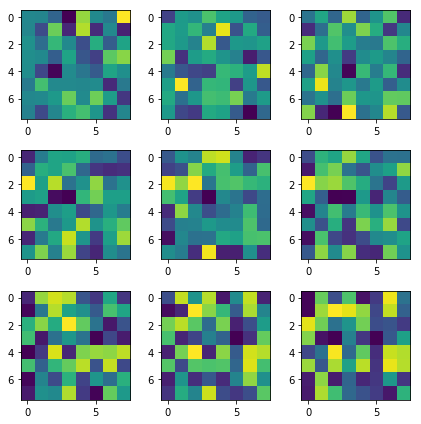

In [118]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
        count += 1

plt.tight_layout();

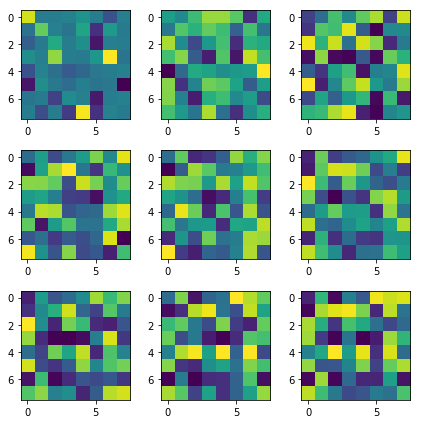

In [121]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
        count += 1

plt.tight_layout();

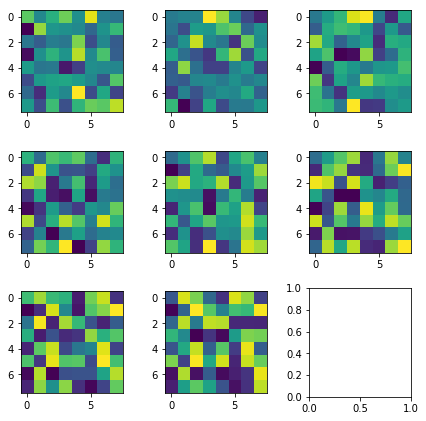

In [124]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(3):
        if count < 8:
            ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
            count += 1

plt.tight_layout();

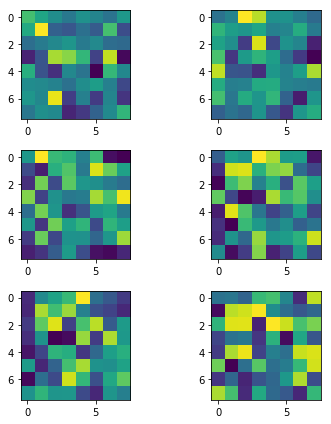

In [129]:
fig, ax = plt.subplots(3, 2, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
        count += 1

plt.tight_layout();

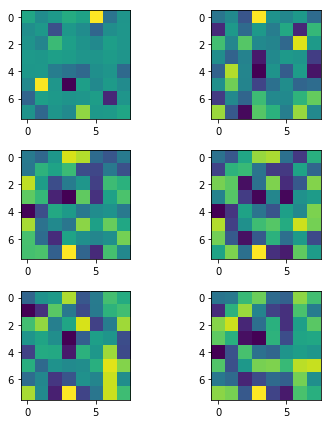

In [131]:
fig, ax = plt.subplots(3, 2, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
        count += 1

plt.tight_layout();

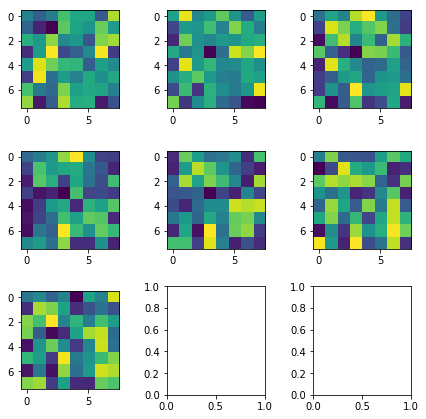

In [136]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(3):
        if count < 7:
            ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
            count += 1

plt.tight_layout();

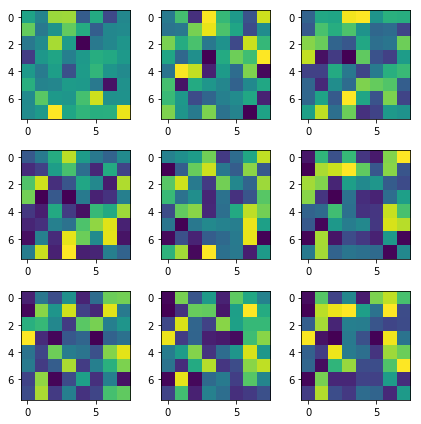

In [139]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
        count += 1

plt.tight_layout();

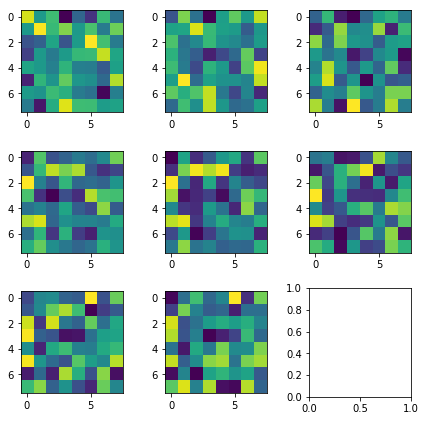

In [142]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(3):
        if count < 8:
            ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
            count += 1

plt.tight_layout();

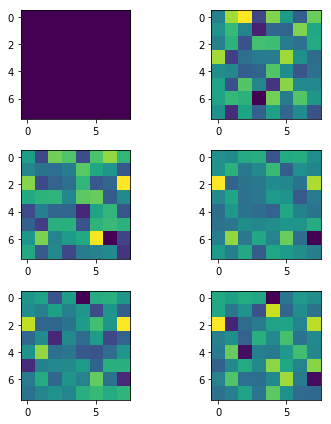

In [93]:
fig, ax = plt.subplots(3, 2, figsize=(6, 6))
count   = 0

for i in range(3):
    for j in range(2):
        ax[i][j].imshow(model.hs[count].cpu().detach().numpy().ravel().reshape(8, 8))
        count += 1

plt.tight_layout();

### Traditional Methods

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 4))),
    ('log_regression', LogisticRegression())
])

model.fit(data_train, labels_train)

In [ ]:
preds      = model.predict(data_test)
preds_prob = model.predict_proba(data_test)

print('Accuracy = {:.2%}'.format(accuracy_score(labels_test, preds)))
print('Log Loss = {:.5f}'.format(log_loss(labels_test, preds_prob)))
print('Classification report:')
print(classification_report(labels_test, preds))